In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1


In [2]:
from configs.pAttention_biogas import hparams
hparams = hparams()
print(hparams)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[('batch_size', 800), ('datagen', 'biogas'), ('in_seq_len', 24), ('input_channels', 1), ('input_dim', 5), ('lambd', 0), ('learning_rate', 0.0031622776601683794), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [3]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields, normalise='global_max')
inp, target, mask, x_max = next(iter(dataset))

Added x, y data
Added y_mask data
Added x_max data
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
class pAttention(tf.keras.Model):
    def __init__(self, mode='var', epsilon = 1e-12):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., name='W_separation')
        self.W2 = tf.Variable(1., name='W_scale')
        self.W3 = tf.Variable(0., name='W_recency')
        self.epsilon = epsilon
        self.w  = None

        if mode == 'var':
            self.variance = self.norm_var
        else:
            self.variance = self.norm_cov

    def cov(self, x):
        """
        Calculate covariance between channels
        """
        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx

    def norm_cov(self, x):
        context = self.cov(x)
        
        context     = tf.reduce_sum(context, axis=1)
        context_max = tf.reduce_max(context, axis=1, keep_dims=True)
        
        return context / (context_max + self.epsilon)

    def var(self, x):
        """
        Calculate variance on difference between channels
        """
        xx = tf.expand_dims(x, axis=-1)
        xx = xx - tf.transpose(xx, [0,1,3,2])
        mu_xx, var_xx = tf.nn.moments(xx, [1])
        
        return var_xx
        
    def norm_var(self, x):
        n_dim  = tf.cast(tf.shape(x)[-1], tf.float32)
        recency = tf.exp(self.W3 * tf.range(n_dim))
        recency = tf.expand_dims(recency, 0)
        
        context = self.var(x) * recency
        
        context     = tf.reduce_sum(context, axis=1)
        context_max = tf.reduce_max(context, axis=1, keep_dims=True)
        
        return (context_max - context) / (context_max + self.epsilon)
        
    def call(self, x, hidden):

        context = self.variance(x)
        
        score   = tf.exp(self.W1) * context
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        self.w  = weights
        
        outputs = self.W2 * tf.reduce_sum(weights * tf.squeeze(x), axis=-1, keepdims=True) 
        
        return outputs

In [6]:
class pAttentionBias(pAttention):
    """
    pAttention model with learnable bias term for model score calculation
    Allows model to learn weights related to recency
    """
    def __init__(self, input_dim, mode='var'):
        super(pAttentionBias, self).__init__()
        # Initialise bias term
        self.b1 = tf.Variable(tf.zeros([input_dim]))
    
    def call(self, x, hidden):
        context = self.variance(x)
        
        score   = tf.exp(self.W1) * context * self.b1
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        self.w  = weights
        
        outputs = self.W2 * tf.reduce_sum(weights * tf.squeeze(x), axis=-1, keepdims=True) 
        
        return outputs

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1 Loss 0.0007 Accuracy 0.0007
Time taken for 1 epoch 0.2330 sec

Epoch 2 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.2057 sec

Epoch 3 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1871 sec

Epoch 4 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1816 sec

Epoch 5 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1732 sec

Epoch 6 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1771 sec

Epoch 7 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1702 sec

Epoch 8 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1792 sec

Epoch 9 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1710 sec

Epoch 10 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1764 sec

Epoch 11 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1714 sec

Epoch 12 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1783 sec

Epoch 13 Loss 0.000

Epoch 109 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1763 sec

Epoch 110 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1732 sec

Epoch 111 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1737 sec

Epoch 112 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1726 sec

Epoch 113 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1748 sec

Epoch 114 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1744 sec

Epoch 115 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1794 sec

Epoch 116 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1725 sec

Epoch 117 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1762 sec

Epoch 118 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1731 sec

Epoch 119 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1753 sec

Epoch 120 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1721 sec

Epoch 121 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1751 sec

Epoch 122 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 223 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1871 sec

Epoch 224 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1817 sec

Epoch 225 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1852 sec

Epoch 226 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1751 sec

Epoch 227 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1796 sec

Epoch 228 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1762 sec

Epoch 229 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1849 sec

Epoch 230 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1829 sec

Epoch 231 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1815 sec

Epoch 232 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1758 sec

Epoch 233 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1905 sec

Epoch 234 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1723 sec

Epoch 235 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1791 sec

Epoch 236 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 337 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1788 sec

Epoch 338 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1741 sec

Epoch 339 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1814 sec

Epoch 340 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1843 sec

Epoch 341 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2028 sec

Epoch 342 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1882 sec

Epoch 343 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1887 sec

Epoch 344 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1911 sec

Epoch 345 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1894 sec

Epoch 346 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1853 sec

Epoch 347 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1941 sec

Epoch 348 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1917 sec

Epoch 349 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1858 sec

Epoch 350 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 451 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1772 sec

Epoch 452 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1750 sec

Epoch 453 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1776 sec

Epoch 454 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1757 sec

Epoch 455 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1803 sec

Epoch 456 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1782 sec

Epoch 457 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1781 sec

Epoch 458 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1844 sec

Epoch 459 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1850 sec

Epoch 460 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1930 sec

Epoch 461 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2049 sec

Epoch 462 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2114 sec

Epoch 463 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1960 sec

Epoch 464 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 564 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1872 sec

Epoch 565 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1754 sec

Epoch 566 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1817 sec

Epoch 567 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1764 sec

Epoch 568 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1797 sec

Epoch 569 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1764 sec

Epoch 570 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1795 sec

Epoch 571 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1774 sec

Epoch 572 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1799 sec

Epoch 573 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1778 sec

Epoch 574 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1833 sec

Epoch 575 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1766 sec

Epoch 576 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1822 sec

Epoch 577 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 678 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1820 sec

Epoch 679 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1788 sec

Epoch 680 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1904 sec

Epoch 681 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1780 sec

Epoch 682 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1813 sec

Epoch 683 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1760 sec

Epoch 684 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1807 sec

Epoch 685 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1803 sec

Epoch 686 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1798 sec

Epoch 687 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1772 sec

Epoch 688 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1816 sec

Epoch 689 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1753 sec

Epoch 690 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1786 sec

Epoch 691 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 792 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1830 sec

Epoch 793 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1775 sec

Epoch 794 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1826 sec

Epoch 795 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1816 sec

Epoch 796 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1812 sec

Epoch 797 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1824 sec

Epoch 798 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1804 sec

Epoch 799 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1821 sec

Epoch 800 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1824 sec

Epoch 801 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1847 sec

Epoch 802 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2047 sec

Epoch 803 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1976 sec

Epoch 804 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1950 sec

Epoch 805 Loss 0.0004 Accuracy 0.0004
Time taken fo

Epoch 905 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2487 sec

Epoch 906 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2586 sec

Epoch 907 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1829 sec

Epoch 908 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1790 sec

Epoch 909 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1755 sec

Epoch 910 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.2095 sec

Epoch 911 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1996 sec

Epoch 912 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1998 sec

Epoch 913 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1779 sec

Epoch 914 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1767 sec

Epoch 915 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1759 sec

Epoch 916 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1823 sec

Epoch 917 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1759 sec

Epoch 918 Loss 0.0004 Accuracy 0.0004
Time taken fo

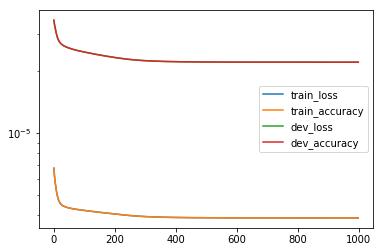

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
[<tf.Variable 'W_separation:0' shape=() dtype=float32, numpy=2.921453>, <tf.Variable 'W_scale:0' shape=() dtype=float32, numpy=0.99999446>, <tf.Variable 'W_recency:0' shape=() dtype=float32, numpy=-0.762644>]
1.3651947124832504e-07


In [7]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = pAttention()
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=1000, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'MicroConvCNN' + get_fields.replace(' ', '_'), stats=stats)
print(model.summary())
print(model.variables)
print(optimizer._lr)

Epoch 1 Loss 0.0007 Accuracy 0.0007
Time taken for 1 epoch 0.2162 sec

Epoch 2 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1777 sec

Epoch 3 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1870 sec

Epoch 4 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1782 sec

Epoch 5 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1805 sec

Epoch 6 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.1807 sec

Epoch 7 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1814 sec

Epoch 8 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1767 sec

Epoch 9 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1801 sec

Epoch 10 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1813 sec

Epoch 11 Loss 0.0005 Accuracy 0.0005
Time taken for 1 epoch 0.1887 sec

Epoch 12 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1792 sec

Epoch 13 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1843 sec

Epoch 14 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.1791 sec

E

Epoch 116 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1821 sec

Epoch 117 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1823 sec

Epoch 118 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1836 sec

Epoch 119 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1781 sec

Epoch 120 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1832 sec

Epoch 121 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1802 sec

Epoch 122 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1816 sec

Epoch 123 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1791 sec

Epoch 124 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1821 sec

Epoch 125 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1793 sec

Epoch 126 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1845 sec

Epoch 127 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1802 sec

Epoch 128 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1870 sec

Epoch 129 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 229 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1837 sec

Epoch 230 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1811 sec

Epoch 231 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1863 sec

Epoch 232 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1793 sec

Epoch 233 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1817 sec

Epoch 234 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1861 sec

Epoch 235 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1887 sec

Epoch 236 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1837 sec

Epoch 237 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1814 sec

Epoch 238 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1805 sec

Epoch 239 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1865 sec

Epoch 240 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1808 sec

Epoch 241 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1839 sec

Epoch 242 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 343 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1834 sec

Epoch 344 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1803 sec

Epoch 345 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1814 sec

Epoch 346 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1810 sec

Epoch 347 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1825 sec

Epoch 348 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1799 sec

Epoch 349 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1860 sec

Epoch 350 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1812 sec

Epoch 351 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1829 sec

Epoch 352 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1801 sec

Epoch 353 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2041 sec

Epoch 354 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1941 sec

Epoch 355 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1816 sec

Epoch 356 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 456 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1856 sec

Epoch 457 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1843 sec

Epoch 458 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1850 sec

Epoch 459 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1801 sec

Epoch 460 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1830 sec

Epoch 461 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1808 sec

Epoch 462 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1834 sec

Epoch 463 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1772 sec

Epoch 464 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1859 sec

Epoch 465 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1763 sec

Epoch 466 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1822 sec

Epoch 467 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1817 sec

Epoch 468 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1849 sec

Epoch 469 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 569 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1873 sec

Epoch 570 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1826 sec

Epoch 571 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1866 sec

Epoch 572 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1812 sec

Epoch 573 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1928 sec

Epoch 574 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1882 sec

Epoch 575 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1852 sec

Epoch 576 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1866 sec

Epoch 577 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1828 sec

Epoch 578 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1839 sec

Epoch 579 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1830 sec

Epoch 580 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1833 sec

Epoch 581 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1859 sec

Epoch 582 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 683 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1900 sec

Epoch 684 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1843 sec

Epoch 685 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1847 sec

Epoch 686 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1816 sec

Epoch 687 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1859 sec

Epoch 688 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1801 sec

Epoch 689 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1842 sec

Epoch 690 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1841 sec

Epoch 691 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1836 sec

Epoch 692 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1801 sec

Epoch 693 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1887 sec

Epoch 694 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1813 sec

Epoch 695 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1865 sec

Epoch 696 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 797 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1843 sec

Epoch 798 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1826 sec

Epoch 799 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1830 sec

Epoch 800 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1817 sec

Epoch 801 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1854 sec

Epoch 802 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1843 sec

Epoch 803 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1867 sec

Epoch 804 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1847 sec

Epoch 805 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1866 sec

Epoch 806 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1862 sec

Epoch 807 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1875 sec

Epoch 808 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1832 sec

Epoch 809 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1859 sec

Epoch 810 Loss 0.0003 Accuracy 0.0003
Time taken fo

Epoch 910 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2482 sec

Epoch 911 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2390 sec

Epoch 912 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2465 sec

Epoch 913 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2385 sec

Epoch 914 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2236 sec

Epoch 915 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1947 sec

Epoch 916 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1876 sec

Epoch 917 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1931 sec

Epoch 918 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1834 sec

Epoch 919 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2445 sec

Epoch 920 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2435 sec

Epoch 921 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.2304 sec

Epoch 922 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.1979 sec

Epoch 923 Loss 0.0003 Accuracy 0.0003
Time taken fo

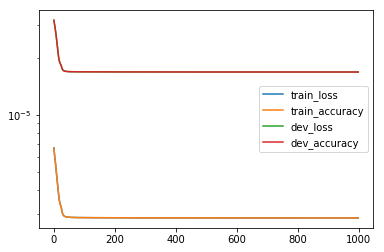

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None
[<tf.Variable 'W_separation:0' shape=() dtype=float32, numpy=2.5346873>, <tf.Variable 'W_scale:0' shape=() dtype=float32, numpy=1.0000086>, <tf.Variable 'W_recency:0' shape=() dtype=float32, numpy=-0.5701507>, <tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([-0.01780312, -0.29834723, -0.33311272, -0.24425144,  0.367127  ],
      dtype=float32)>]
1.3651947124832504e-07


In [8]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model_ = pAttentionBias(hparams.input_dim)
optimizer_ = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams,
                                                      epochs=1000, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'MicroConvCNN' + get_fields.replace(' ', '_'), stats=stats)
print(model_.summary())
print(model_.variables)
print(optimizer_._lr)

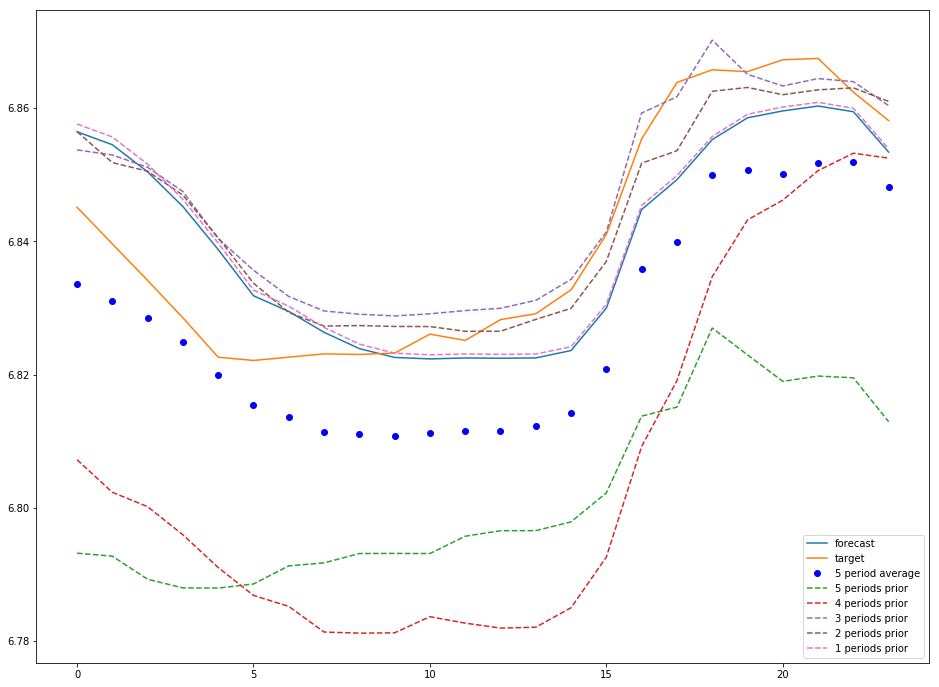

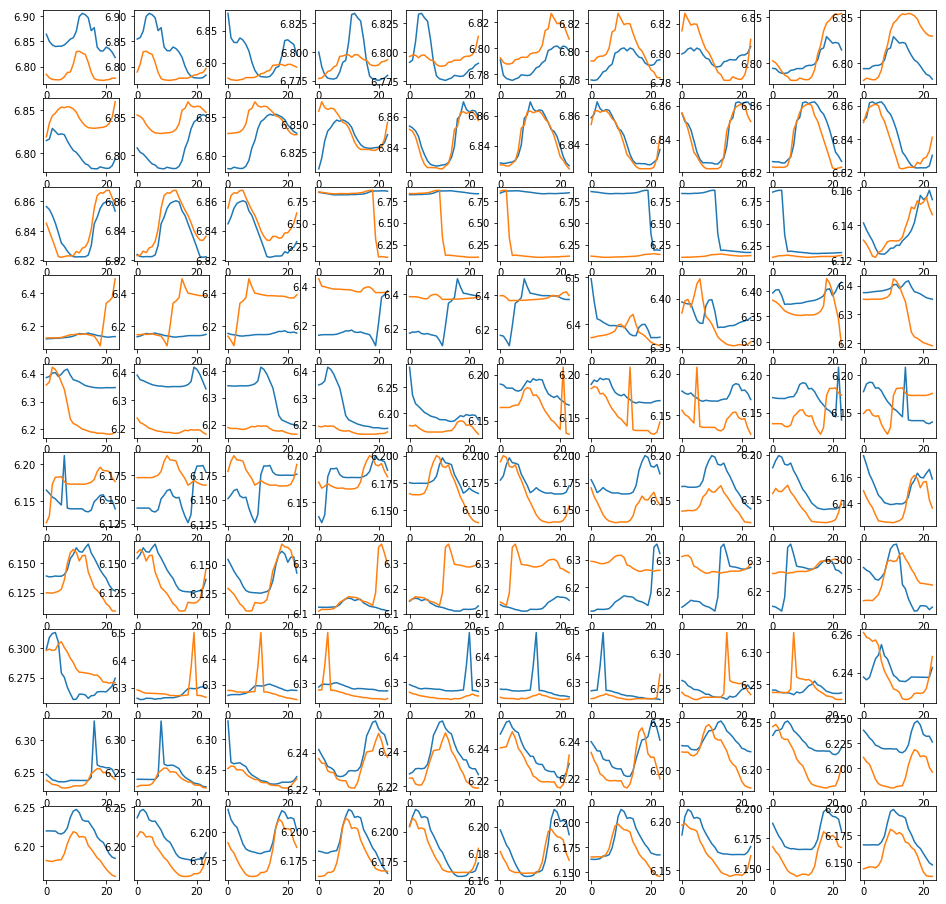

In [9]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 160

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset))
x_max = tf.expand_dims(x_max,-1)
forecast = model_(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max

# Plot target sequence
#print('Attention Weights: ', ['{:.1f}'.format(i * 100) for i in model.attn.w[TARGET_INDEX,0]])
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i], '--', label='%i periods prior' % (hparams.input_dim-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [11]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model__ = pAttention()
    optimizer__ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model__, optimizer__, dataset, hparams, epochs = 50, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model__)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0639 Accuracy 0.0639 Time 8.4
Learning Rate -3.5000 Loss 0.0590 Accuracy 0.0590 Time 8.1
Learning Rate -3.0000 Loss 0.0488 Accuracy 0.0488 Time 8.0
Learning Rate -2.5000 Loss 0.0435 Accuracy 0.0435 Time 8.0
Learning Rate -2.0000 Loss 0.0385 Accuracy 0.0385 Time 8.1
Learning Rate -1.5000 Loss 0.0334 Accuracy 0.0334 Time 8.0
Learning Rate -1.0000 Loss 0.0294 Accuracy 0.0294 Time 8.0
Learning Rate -0.5000 Loss 0.0294 Accuracy 0.0294 Time 9.1


Learning Rate -3.5000 Loss 0.0254 Accuracy 0.0254 Time 32.2
Learning Rate -3.0000 Loss 0.0247 Accuracy 0.0247 Time 31.2
Learning Rate -2.5000 Loss 0.0254 Accuracy 0.0254 Time 31.5

## Test Model Accuracy

#### pAttention Model

In [12]:
model_accuracy = []

Train Results
Total RSE Accuracy: 0.0705
Total MSE Accuracy: 0.0062
Test Results
Total RSE Accuracy: 0.0519
Total MSE Accuracy: 0.0046


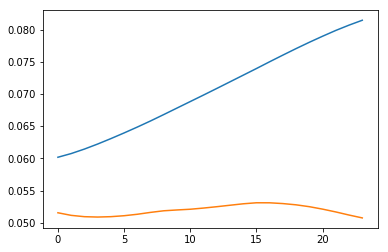

In [13]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

#### pAttentionBias Model

In [14]:
model_accuracy_ = []

Train Results
Total RSE Accuracy: 0.0516
Total MSE Accuracy: 0.0045
Test Results
Total RSE Accuracy: 0.0359
Total MSE Accuracy: 0.0032


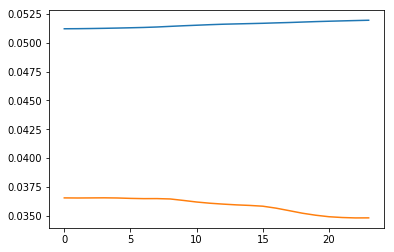

In [15]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy_ = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model_(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy_.append(accuracy)

    model_accuracy_.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy_))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy_) * x_variance))
    plt.plot(np.mean(total_accuracy_, axis=0))
plt.show()